In [13]:
#Cambio con respecto a SimulationTest8: Hay cosas que faltan todavía por hacer que se han empezado o propuesto en SimulationTest7 pero este cambio es
#principalmente para adaptar el código a que la clase robots no tenga totes, sino que sea la interfaz la que te lo de

#También se añade la función genera_ola que te genera una serie de pedidos cada cierto tiempo dependiendo de la demanda
#Para llamar a esta función desde el main sería necesario declarar la variable de tiempo y empezar a crear todo el sistema que simula el tiempo

#Hay que añadir una manera en la que se cambien los valores de los números random dependiendo del mapa escogido

#Se ha incluido una función de mover robot y otra de generar ruta en el caso de que haya interseccion pero hay que comprobar que ambas funcionen

#Hay que crear una funcion para que todos los robots al empezar un pedido salgan desde un lugar concreto 
#y cuando entregue el pedido que se quite del mapa

#Hay que hacer que una vez que llega a la posicion de picking, el robot se pare

#Hay que hacer que una vez que le visita el humano al robot y hace el picking, el robot calcule ruta y siga a la siguiente posicion

#Hay que hacer y comprobar que las variables se guardan en el csv

In [14]:
# Import general
import pandas as pd
import numpy as np
import array

# Import para mapa
from matplotlib import pyplot
from matplotlib import colors
import pickle

#Import para generar ruta
import heapq
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# Import para clases
from abc import ABC

# Import para comprobar ruta
import copy

# Import para generar pedido
import random
from math import sqrt
from numpy import vectorize

# Import para Recopilar datos
from pathlib import Path

In [15]:
# Clases

class Robot(ABC):
    def __init__(self, ID: int, vel: float):
        self._ID = ID  # ID del robot
        self._vel: float = vel  # Velocidad del robot
        self._pos = []  # Posición en matriz array, es un vector
        self._pedidos: int = 0  # Número de pedidos que ha realizado
        self._numpicks: int = 0  # Número de picks realizados
        self._picks: int = 0  # Vector de posiciones de picks del robot
        self._ruta = []  # Array de Arrays

        self._proceso: int = 0  # Proceso que se encuentra el robot
        # 0: espera, 1: movimiento, 2: llegada a pick sin humano, 3: humano haciendo picking, 4: yendo a descarga, 5: descarga
        #Asumimos que no tarda nada en descargar y que una vez que llega a descarga ya está disponible para hacer otra mision

        self._dist: float = 0.0  # Distancia recorrida por el robot
        self._dist_metros: float = 0.0  # Distancia recorrida en metros
        self._intersec: int = 0  # Intersecciones entre robots encontradas
        self._tiempoespera: float = 0.0  # Tiempo del robot esperando a humano
        self._tsalida: float = 0.0  # Tiempo de salida del robot
        self._misions: int = 0

    def get_ID(self) -> int:
        return self._ID

    def set_ID(self, ID: int):
        self._ID = ID

    def get_vel(self) -> float:
        return self._vel

    def set_vel(self, vel: float):
        if vel > 0:
            self._vel = vel

    def get_pos(self) -> array.array:
        return self._pos

    def set_pos(self, pos):
        self._pos = pos

    def get_pedidos(self) -> int:
        return self._pedidos

    def set_pedidos(self, pedidos):
        if pedidos > 0:
            self._pedidos = pedidos   

    def get_numpicks(self) -> int:
        return self._numpicks

    def set_numpicks(self, numpicks):
        if numpicks > 0:
            self._numpicks = numpicks  

    def get_picks(self) -> int:
        return self._picks

    def set_picks(self, picks):
        if picks > 0:
            self._picks = picks  

    def get_ruta(self) -> array.array:
        return self._ruta

    def set_ruta(self, ruta):
        if ruta > 0:
            self._ruta = ruta       

    def get_proceso(self) -> int:
        return self._proceso

    def set_proceso(self, proceso: int):
        if proceso >= 0 and proceso <= 3:
            self._proceso = proceso

    def get_dist(self) -> int:
        return self._dist

    def set_dist(self, dist: int):
        if dist >= 0:
            self._dist = dist

    def get_dist_metros(self) -> int:
        return self._dist_metros

    def set_dist_metros(self, dist_metros: int):
        if dist_metros >= 0:
            self._dist_metros = dist_metros

    def get_intersec(self) -> int:
        return self._intersec

    def set_intersec(self, intersec: int):
        if intersec >= 0:
            self._intersec = intersec

    def get_tiempoespera(self) -> float:
        return self._tiempoespera

    def set_tiempoespera(self, tiempoespera: float):
        if tiempoespera > 0:
            self._tiempoespera = tiempoespera

    def get_tsalida(self) -> float:
        return self._tsalida

    def set_tsalida(self, tsalida: float):
        if tsalida > 0:
            self._tsalida = tsalida

    def get_misions(self) -> int:
        return self._misions

    def set_misions(self, misions: int):
        if misions >= 0:
            self._misions = misions


class Humano(ABC):
    def __init__(self, ID: int, vel: float, picktime: float):
        self._ID = ID  # ID del humano
        self._vel: float = 1.0  # Velocidad del humano
        self._pos = (0,0) # Posición del humano en matriz
        self._goal = [] # Posicion del pick al que va el humano
        self._ruta = []  # Array de Arrays
        self._picktime: float = 15.0  # Tiempo que tarda en hacer el pick
        self._procesopick: int = 0  # Cuántos segundos lleva el humano haciendo el pick
        self._dist: float = 0.0 # Distancia recorrida por el humano

        self._proceso: int = 0  # Proceso en el que está el humano
        # 0: parado, 1: yendo a pick, 2: picking

        self._tiempototal: float = 0.0  # Tiempo del humano en el pedido

        self._picks = [] # Posición del siguiente robot al que tiene que ir el humano

    def get_ID(self) -> int:
        return self._ID

    def set_ID(self, ID: int):
        self._ID = ID

    def get_vel(self) -> float:
        return self._vel

    def set_vel(self, vel: float):
        if vel > 0:
            self._vel = vel

    def get_ruta(self) -> array.array:
        return self._ruta

    def set_ruta(self, ruta: array.array):
        self._ruta = ruta

    def get_goal(self):
        return self._goal

    def set_goal(self, goal):
        self._goal = goal

    def get_pos(self):
        return self._pos

    def set_pos(self, pos):
        self._pos = pos

    def get_picktime(self) -> float:
        return self._picktime

    def set_picktime(self, picktime: float):
        if picktime > 0:
            self._picktime = picktime

    def get_dist(self) -> float:
        return self._dist

    def set_dist(self, dist: float):
        if dist > 0:
            self._dist = dist

    def get_proceso(self) -> int:
        return self._proceso

    def set_proceso(self, proceso: int):
        if proceso >= 0 and proceso <= 4:
            self._proceso = proceso

    def get_tiempototal(self) -> float:
        return self._tiempototal

    def set_tiempototal(self, tiempototal: float):
        if tiempototal > 0:
            self._tiempototal = tiempototal

    def get_picks(self):
        return self._ruta

    def set_picks(self, picks):
        self._picks = picks


In [16]:

map_list = []
vmap = []

#Mapa Cortefiel - Variable = 0

def m_CTF():
    map_CTF = np.ones((64, 121))

    for i in range(map_CTF.shape[1]):
        if (i % 2) == 0:
            map_CTF[:, i] = 0

    map_CTF[:3, :] = 0
    map_CTF[-5:, :] = 0
    map_CTF[-3:, :11] = 1
    map_CTF[25:27, :] = 0
    map_CTF[41:43, :] = 0
    map_CTF[-15:, 29:41] = 0
    map_CTF[11:14, 24] = 1
    map_CTF[45:48, 24] = 1
    map_CTF[11:14, 60] = 1
    map_CTF[11:14, 76] = 1
    map_CTF[9:12, 75] = 0
    map_CTF[14, 75] = 0
    map_CTF[11:13, 77] = 0
    map_CTF[-9:-6, 52] = 1
    map_CTF[-9:-6, 74] = 1
    map_CTF[-6, 70:77] = 0
    map_CTF[11:14, 104] = 1
    map_CTF[45:48, 104] = 1
    map_CTF[9:12, 103] = 0
    map_CTF[14, 103] = 0
    map_CTF[11:13, 105] = 0
    map_CTF[-12:-10, 73] = 0
    map_CTF[46:49, 103] = 0
    map_CTF[43:45, 105] = 0


    map_list = map_CTF.tolist()

    colormap = colors.ListedColormap(["white", "grey"])
    # entregando este problema a
    pyplot.imshow(map_list, cmap=colormap)
    pyplot.show()

    map_array = map_CTF


    return map_array, map_list


In [17]:
# Mapa Layout SPF - Variable = 1

def m_SPF():

    map_SPF = np.ones((57, 165), dtype=int)

    for i in range(map_SPF.shape[1]):
        if (i % 2) == 0:
            map_SPF[:, i] = 0

    map_SPF[0, :] = 0  # Fila 0 vacia
    map_SPF[11:13, :] = 0  # Fila gruesa vacia
    map_SPF[30:32, :] = 0  # Fila gruesa vacia
    map_SPF[:, 160:165] = 0  # Columna gruesa final vacia
    map_SPF[53:57, 0:38] = 0  # Zona inferior izquierda vacia
    map_SPF[48:57, 38:42] = 0  #
    map_SPF[43:47, 42:57] = 0  #
    map_SPF[47:57, 43:55] = 1  # Hueco ocupado "exterior"
    map_SPF[48:57, 56:63] = 0  #
    map_SPF[48:50, 63:156] = 0  # Filas que separan la zona de recogida vacias
    map_SPF[48:57, 156:164] = 0  #
    map_SPF[50:57, 63:156] = 1  # Zona de recogida ocupada
    map_SPF[51, 7:10] = 0  # Hueco encima de una escalera
    # Huecos intercalados:
    map_SPF[16:20, 32:37] = 0  # Hueco a
    map_SPF[16:20, 58:63] = 0  # Hueco b
    map_SPF[16:20, 88:93] = 0  # Hueco e
    map_SPF[16:20, 114:119] = 0  # Hueco g
    map_SPF[16:20, 146:151] = 0  # Hueco i
    map_SPF[37:41, 32:37] = 0  # Hueco d
    map_SPF[37:41, 58:63] = 0  # Hueco c
    map_SPF[37:41, 88:93] = 0  # Hueco f
    map_SPF[37:41, 114:119] = 0  # Hueco h
    map_SPF[37:41, 146:151] = 0  # Hueco j
    # Escaleras:
    map_SPF[7:11, 10:12] = 1  #
    map_SPF[7:11, 38:40] = 1  #
    map_SPF[7:11, 74:76] = 1  #
    map_SPF[7:11, 90:92] = 1  #
    map_SPF[7:11, 118:120] = 1  #
    map_SPF[7:11, 154:156] = 1  #
    map_SPF[52:56, 7:10] = 1  #
    map_SPF[41:45, 38:40] = 1  #
    map_SPF[42:46, 118] = 1  #
    # Cuadrados azules derecha:
    map_SPF[2:4, 162:165] = 1  #
    map_SPF[22:24, 162:165] = 1  #
    map_SPF[38:40, 162:165] = 1  #
    map_SPF[53:55, 162:165] = 1  #
    # Cuadrados azules abajo:
    map_SPF[50:52, 40:43] = 1  #
    map_SPF[50:52, 56:59] = 1  #
    # Columnas verdes:
    map_SPF[16:18, 6:9] = 1  #
    map_SPF[16:18, 33:36] = 1  #
    map_SPF[16:18, 60:63] = 1  #
    map_SPF[16:18, 89:92] = 1  #
    map_SPF[16:18, 116:119] = 1  #
    map_SPF[16:18, 149:152] = 1  #
    map_SPF[38:40, 6:9] = 1  #
    map_SPF[38:40, 33:36] = 1  #
    map_SPF[38:40, 60:63] = 1  #
    map_SPF[38:40, 89:92] = 1  #
    map_SPF[38:40, 116:119] = 1  #
    map_SPF[38:40, 149:152] = 1  #


    map_list = map_SPF.tolist()

    colormap = colors.ListedColormap(["white", "grey"])
    # entregando este problema a
    pyplot.imshow(map_list, cmap=colormap)
    pyplot.show()

    map_array = map_SPF


    return map_array, map_list

In [18]:
# Función Recopilar

def data_CSV(
    ID,
    Numpicks,
    Totaltime,
    Tiempoespera,
    Tiemposalida,
    Misions,
    Distance,
    DistanceMeters,
    Intersections,

):

    #This function creates a new CSV or updates an existing one with the given data

    dataArray = [
        ID,
        Numpicks,
        Totaltime,
        Tiempoespera,
        Tiemposalida,
        Misions,
        Distance,
        DistanceMeters,
        Intersections,

    ]

    column_names = [
        "ID Robot",
        "Number of picks",
        "Tiempo Total",
        "Tiempo espera a humano",
        "Tiempo de salida",
        "Misiones Completadas",
        "Distancia",
        "Distancia en metros",
        "Intersecciones",

    ]

    file_path = Path("/Users/jaimejarauta/Downloads/data.csv") #Habría que ajustar el directorio para cada ordenador
    if file_path.exists():
        data = pd.DataFrame([dataArray])
        data.to_csv(file_path, mode="a", index=False, na_rep="Unknown", header=False)
    else:
        data = pd.DataFrame([dataArray], columns=column_names)
        data.to_csv(
            file_path, mode="a", index=False, na_rep="Unknown", header=column_names
        )


In [19]:
# Función Generar Ruta
#https://www.analytics-link.com/post/2018/09/14/applying-the-a-path-finding-algorithm-in-python-part-1-2d-square-grid

# heuristic function for path scoring

def heuristic(a, b):

    return np.sqrt((b[0] - a[0]) ** 2 + (b[1] - a[1]) ** 2)
 
# path finding function
 
def generar_ruta(array, start, goal):
    neighbors = [(0,1),(0,-1),(1,0),(-1,0),(1,1),(1,-1),(-1,1),(-1,-1)]
    #(1,1),(-1,1),(1,-1),(-1,-1) Quitamos movimientos diagonales
    close_set = set()

    came_from = {}
    gscore = {start:0}
    fscore = {start:heuristic(start, goal)}

    oheap = []
    heapq.heappush(oheap, (fscore[start], start))

    while oheap:
        current = heapq.heappop(oheap)[1]
        if current == goal:
            data = []

            while current in came_from:

                data.append(current)
                current = came_from[current]
            data = data + [start]
            data = data[::-1]
            return data
        close_set.add(current)

        for i, j in neighbors:

            neighbor = current[0] + i, current[1] + j
            tentative_g_score = gscore[current] + heuristic(current, neighbor)

            if 0 <= neighbor[0] < array.shape[0]:

                if 0 <= neighbor[1] < array.shape[1]:                

                    if array[neighbor[0]][neighbor[1]] == 1:
                        continue

                else:

                    # array bound y walls
                    continue

            else:

                # array bound x walls
                continue

            if neighbor in close_set and tentative_g_score >= gscore.get(neighbor, 0):

                continue

            if  tentative_g_score < gscore.get(neighbor, 0) or neighbor not in [i[1]for i in oheap]:

                came_from[neighbor] = current
                gscore[neighbor] = tentative_g_score
                fscore[neighbor] = tentative_g_score + heuristic(neighbor, goal)
                heapq.heappush(oheap, (fscore[neighbor], neighbor))
 
    return False


In [20]:
# Función Generar Pedido

def distance(p1, p2):  # Función para calcular la distancia euclidiana y optimizar orden de ruta
    return sqrt((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2)

def generar_pos(section = 0, demanda = 0):

    i = 0
    # y es el valor que establece si el vector es correcto o no 
    # 0: incorrecto, 1: Correcto

    while i == 0:

        if demanda == 0:    # Generación de posición con demanda baja (todo el almacén)
            num1 = random.randint(1, len(map_list)) # Valor random del eje x
            num2 = random.randint(1, len(map_list[0])) # Valor random del eje y

        elif demanda == 1:    # Generación de posición con demanda alta (un tercio del almacén)
            num1 = random.randint(1, len(map_list))

            if section == 1:
                num2 = random.randint((0, len(map_list[0])/3))
            elif section == 2:
                num2 = random.randint((len(map_list[0])/3, 2*len(map_list[0])/3))
            elif section == 3:
                num2 = random.randint((2*len(map_list[0])/3, 3*len(map_list[0])/3))

        x = 0 
        
        """x es el número de "0" que hay en las 9 posiciones contiguas a la
        selección. Si hay 4 o menos "0", la selección será válida
        (ya que no está en los pasillos). Si hay más de 4 "0" significa que
        está en un pasillo u otro espacio en el que no hay estantería"""

        # Comprueba las 9 casillas contiguas en las que hay "0"

        if vmap[num1 + 1, num2] == 0:
            x = x + 1

        if vmap[num1 + 1, num2 + 1] == 0:
            x = x + 1

        if vmap[num1, num2 + 1] == 0:
            x = x + 1

        if vmap[num1 - 1, num2 + 1] == 0:
            x = x + 1

        if vmap[num1 - 1, num2] == 0:
            x = x + 1

        if vmap[num1 - 1, num2 - 1] == 0:
            x = x + 1

        if vmap[num1, num2 - 1] == 0:
            x = x + 1

        # Comprueba que la posición está libre y hay 4 o menos casillas con "0"
        if x <= 4 and vmap[num1, num2] == 0:
            i = 1
            vector = np.array([num1, num2])

        # Caso en el que la selección no es válida
        if x > 4 or vmap[num1, num2] == 1:
            i = 0

    return (num1,num2)


def generar_pedido(agente, picks, demanda):

    vec = []

    if demanda == 0:    # Baja demanda. Los robots se mueven por todo el almacén

        for i in range(0, picks - 1):

            pos = generar_pos()  # Genera una posición aleatoria
            vec.append(pos)   # Añade la posición al vector de picks
                

    if demanda == 1: # Alta demanda. Los robots se mueven en tres secciones divididas del almacén
        section = random.randint(1, 3)

        for i in range(0, picks - 1):

            pos = generar_pos(section, demanda) # Genera una posición aleatoria dependiendo de demanda
            vec.append(pos)    # Añade la posición al vector de picks
                
    vec.insert(0, agente._pos) # Añade la posición del robot al vector de picks
    agente._picks = ordenar_ruta(agente._picks)
    agente._picks.pop(0) # pop porque se repetía el primer vector 2 veces por alguna razón

    #Creo que esto no es necesario (comprobar)
    """#Llamada a generar_ruta para que vaya desde la posición de inicio a la posición del primer pedido
    agente._ruta = generar_ruta(vmap, agente._pos, agente._picks[0])""" 

    generar_siguiente_ruta(agente)

    return agente._picks


#Function that orders vector of picks to execute the route with the shortest distance
def ordenar_ruta(ruta):
    ruta_ordenada = []
    ruta_ordenada.append(ruta[0])
    for i in range(len(ruta)):
        d_min = 100000
        for j in range(len(ruta)):
            d = distance(ruta_ordenada[i], ruta[j])
            if d < d_min:
                d_min = d
                pos_min = ruta[j]
                pos_min_index = j
        ruta_ordenada.append(pos_min)
        ruta.pop(pos_min_index)
    return ruta_ordenada


def generar_siguiente_ruta(agente):
    ruta = generar_ruta(vmap, agente._pos, agente._picks[1]) #Comprobar si cuando se ejecuta, en agente._picks hay que poner [0] o [1]

    for j in range(len(ruta)):
        agente._ruta.append(ruta[j])

    return agente._ruta



In [21]:
def mov_humano(humanos, robots, xmap):

    global pos_min, pos_min_index # Se hace para evitar un error "local variable '-' referenced before assignment:"
    h = 0 # Variable que se usa para que no se asigne humanos[i]._picks[1] en el caso de que no haya ningun robot en proceso 2 (da error si no se hace)

    for i in range(len(humanos)):

        if humanos[i]._proceso == 0: # Si el humano no está en proceso de atender a un pedido
            d_min = 100000 # Distancia mínima inicializada a un valor muy alto

            for j in range(len(robots)): #Se busca el robot que esté en la posición más cercana al humano y esté esperando
                
                if robots[j]._proceso == 2:

                    d = ((humanos[i]._pos[0] - robots[j]._pos[0]) ** 2 + (humanos[i]._pos[1] - robots[j]._pos[1]) ** 2)**0.5
                    if d < d_min:
                        d_min = d
                        pos_min = robots[j]._pos
                        pos_min_index = j
                        h = 1

            if h == 1: # Si se ha encontrado un robot en espera

                humanos[i]._picks.append(0, robots[pos_min_index]._pos) #Se asigna la posición del robot al humano (se hace picks[1] para que funciones generar_siguiente_ruta)
                humanos[i]._goal.append(0, robots[pos_min_index]._pos) #Se asigna la posición del robot al humano (se hace goal[0] para que funcione la siguiente parte del cod)
                generar_siguiente_ruta(humanos[i]) # Se genera la ruta del humano


        if humanos[i]._proceso == 1: # Si el humano está en proceso de atender a un pedido

            if humanos[i]._pos != humanos[i]._goal[0]: #Si el humano no está en la posición final
                humanos[i]._pos = humanos[i].ruta[0] #Se mueve a la siguiente posición
                humanos[i]._ruta.pop(0) #Se elimina la posición actual del vector de ruta
                humanos[i]._dist = humanos[i].dist + 1 #Se añade 1 posicion a la distancia

            elif humanos[i]._pos == humanos[i]._goal[0]: #Si el humano está en la posición final
                humanos[i]._proceso = 2 #Se cambia el estado del humano a 2 (hacer el picking)

                for j in range(len(robots)): #Se busca el robot que esté en la posición del humano
                    if robots[j]._pos == humanos[i]._goal[0]:
                        robots[j]._proceso = 3 #El humano está haciendo el pick
                        humanos[i]._procesopick = humanos[i]._procesopick + 1 #Añade 1 segundo al proceso de pick

                if humanos[i]._procesopick >= humanos[i]._picktime: #Si ha terminado de hacer el pick
                    humanos[i]._procesopick = 0 #Se pone el humano en búsqueda
                    robots[i]._pick.pop(1) #Se elimina el segundo elemento del vector de picks para que el robot vaya al siguiente (el primero es su pos actual)
                    humanos[i]._goal.pop(0)
                    humanos[i]._picks.pop(0)
                    
                    if len(robots[j]._pick) == 1: #Si el robot no tiene pedidos (es decir, en su vector pick está sólo su pos actual), va a descargar
                        robots[j]._proceso = 4 #Se cambia el estado del robot a 4 (yendo a descargar)

                        if xmap == 1: #Si el mapa es SPF
                            zonadescarga = random.randint(64, 153) #Asigna una zona de descarga aleatoria para que no haya interferencias
                            robots._pick.append(49, zonadescarga)

                        elif xmap == 0: #Si el mapa es CTF
                            zonadescarga = random.randint(40, 115) #Comprobar que esta es la zona de descarga de CTF
                            robots._pick.append(63, zonadescarga) #Añade el pedido al vector de picks
                            
                        generar_siguiente_ruta(robots[j]) #Genera la ruta del robot

                    else:  # Si el robot tiene pedidos, va a ir a coger el siguiente
                        robots[j]._proceso = 1 #Se cambia el estado del robot a 1 (yendo a pedido)
                        generar_siguiente_ruta(robots[j]) #Genera la ruta del robot
                    

    return

In [22]:
# Función mover robots dependiendo del tiempo (comprobar que funciona)

def mov_robot(robots, t):
    for i in range(len(robots)):

        if robots[i]._proceso != 0 and robots[i]._proceso != 5: #Si el robot no está en proceso de espera o descarga

            m = 0

            while m != 1:


                if robots[i]._pos != robots[i]._picks[1]: # Si no está en la posición de su próximo pedido (es decir, en proceso 1 o 4)

                    r = 0

                    while r == 0: #While para que no pase hasta que no se haya movido el robot
                    
                        if vmap(robots[i]._ruta[0]) == 0 and vmap(robots[i]._ruta[1]) == 0: 
                            #Comprueba que no hay nadie en sus 2 siguientes posiciones
                            robots[i]._pos = robots[i]._ruta.pop(0) #Cambia la posicion del robot a la siguiente posicion de la ruta
                            robots[i]._picks[0] = robots[i]._pos #Cambia la posicion del robot en el vector de picks (la pos 0 de picks es la posicion actual)
                            robots[i]._dist = robots[i]._distancia + 1 #Añade 1 posicion a la distancia

                            if robots[i]._pos == robots[i]._picks[1]: #Si ha llegado a la posicion del pedido
                                robots[i]._proceso = 2 #Se cambia el estado del robot a 2 (hacer el picking)

                            m = 1
                            r = 1

                        elif vmap(robots[i]._ruta[0]) == 1 or vmap(robots[i]._ruta[1]) == 1: 
                            # Si cualquiera de las dos siguientes posiciones de la ruta están ocupadas

                            #Asigna el valor de la siguiente posición de todos los robots como 1 para que no haya intersecciones
                            array = vmap
                            for j in range(len(robots)): #Se recorre el vector de robots y asigna la siguiente posicion de cada robot como ocupada
                                if robots[j]._proceso == 1:
                                    array(robots[j]._ruta[1]) == 1

                            #Recalcula la ruta con una matriz secundaria array en la que están la siguiente posición de cada robot ocupadas
                            robots[i]._ruta = generar_ruta(array, robots[i]._pos, robots[i]._picks[1])
                            robots[i]._intersec = robots[i]._intersec + 1 #Añade 1 intersección a la cantidad de intersecciones
            

                if robots[i]._pos == robots[i]._picks[1]: #Si el robot está en la posición del pedido
                    robots[i]._proceso = 2 #Se cambia el estado del robot a 2 (hacer el picking)
                    robots[i]._tiempoespera = robots[i]._tiempoespera + 1.4 #Añade 1.4 segundos a los tiempos de espera
                    m = 1

                if robots[i]._proceso == 4 and robots[i]._pos == robots[i]._picks[0]:  # Si el robot está en la posición de descarga

                    #Si ha llegado a la descarga, cambia a espera y su vector ruta, posicion y pick se vuelve 0
                    
                    robots[i]._tiempototal = robots[i]._tsalida - t #Calcula el tiempo total de la descarga
                    robots[i]._dist_metros = robots[i]._dist * 1.3 #Calcula la distancia en metros

                    print("Creamos CSV")
                    data_CSV(
                        robots[i]._ID, 
                        robots[i]._numpicks, 
                        robots[i]._tiempototal, 
                        robots[i]._tiempoespera,
                        robots[i]._tsalida, 
                        robots[i]._misions, 
                        robots[i]._dist, 
                        robots[i]._dist_metros, 
                        robots[i]._intersec) #Guarda los datos en un fichero CSV

                    
                    robots[i]._numpicks = 0 #Se pone el número de picks a 0
                    robots[i]._proceso = 0 #Se pone el proceso a 0 (espera)
                    robots[i]._ruta = [] #Se elimina el vector de ruta
                    robots[i]._picks = [] #Se elimina el vector de picks
                    robots[i]._pos = [] #Se elimina la posicion
                    robots[i]._intersec = 0 #Se pone la cantidad de intersecciones a 0
                    robots[i]._tiempoespera = 0.0 #Se pone el tiempo de espera a 0
                    robots[i]._tiempototal = 0.0
                    robots[i]._dist = 0 #Se pone la distancia a 0
                    robots[i]._dist_metros = 0 #Se pone la distancia en metros a 0
                    robots[i]._tsalida = 0.0 #Se pone el tiempo de salida a 0

                    m = 1                    

                return 1

    return 0


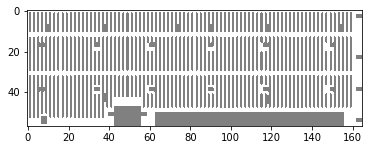

In [23]:
# Declaración variables incluidas en interfaz

#Declaramos mapa dependiendo del introducido en la interfaz
#La variable del mapa se ha creado antes

xmap = 1 #0: CTF, 1: SPF

if xmap == 0:
    vmap, map_list = m_CTF() #Carga el mapa CTF

elif xmap == 1:
    vmap, map_list = m_SPF() #Carga el mapa SPF

# vmap = variable del mapa

# Declaración de variables introducidas en interfaz

numrobot = 20 #Número de robots
numhumano = 5 #Número de humanos
movhumano = 0 #Tipo de movimientos de humanos (de momento no lo usamos)

d_simulacion = 100 #8640000 = 100 dias en segundos
d_demanda_alta = 30 #2592000 = 30 dias en segundos
d_demanda_baja = d_simulacion - d_demanda_alta #6048000 = 70 dias en segundos

s_simulacion = d_simulacion * 60 * 60 * 24 #8640000 = 100 dias en segundos
s_demanda_alta = d_demanda_alta * 60 * 60 * 24 #2592000 = 30 dias en segundos
s_demanda_baja = d_demanda_baja * 60 * 60 * 24 #6048000 = 70 dias en segundos

tiempoola = 3600  # Tiempo entre cada ola

misiones_ola_manana = (15, 20) # Rango de Misiones por ola de la mañana
misiones_ola_tarde = (10, 15) # Rango de Misiones por ola de la tarde
misiones_ola_noche = (5, 10) # Rango de Misiones por ola de la noche

totes_mision = (6, 12) # Rango de totes por cada mision (pedidos)

picks_tote = (1, 3) # Rango de picks por tote


# Inicialización variables de tiempo

t = 0.0 #tiempo total simulación
tdia = 0.0 #tiempo del dia (0s a 86400s)
zdia = 0 #zona del dia (0 = dia, 1 = tarde, 2 = noche) (0s-28800s, 28800s-57600s, 57600s-86400s)
tola = 0.0 #tiempo de ola (0s a tiempoola s)
tmov = 0.0 #tiempo de movimiento de robots y humanos

tejec = 0.0 #tiempo de ejecución de la simulación (sólo sirve para testear y hacer print, hay que quitar luego)


#Función declarar instancias dependiendo de variables introducidas por el usuario

robots = []
robots = [Robot(x, 0.9) for x in range(0, numrobot - 1)]

humanos = []
humanos = [Humano(x, 1, 15) for x in range(0, numhumano - 1)]

for i in range(numhumano - 1): #Inicializamos los humanos en un punto random del mapa
    humanos[i]._pos = (random.randint(len(map_list), len(map_list[0])))

In [24]:
while t <= s_simulacion:

    if tola > tiempoola: 

        if t in range(0, s_demanda_alta):
            demanda = 1

        else: 
            demanda = 0

        if tdia in range(0, 28800): #Mañana
            zdia = 0
            mis = random.randint(misiones_ola_manana[0], misiones_ola_manana[1])

        if tdia in range(28800, 57600): #Tarde
            zdia = 1
            mis = random.randint(misiones_ola_tarde[0], misiones_ola_tarde[1])

        if tdia in range(57600, 86400): #Noche
            zdia = 2
            mis = random.randint(misiones_ola_noche[0], misiones_ola_noche[1])

        if tdia > 86400:
            tdia = 0 #Reinicia el tiempo del dia
            zdia = 0 #Reinicia la zona del dia a mañana

        tola = 0 #Reinicia el tiempo de ola

        k = 0
        j = random.randint(0, numrobot - 1)

        while k < mis:

            while robots[j]._proceso != 0:

                #Hay que poner que si no hay robots disponibles, no se pueda generar una nueva mision
                
                if robots[j]._proceso == 0:
                    totes = random.randint(totes_mision[0], totes_mision[1])
                    robots[j]._pedidos = totes
                    robots[j]._proceso = 1
                    robots[j]._tsalida = t
                    robots[j]._misions = robots[j]._misions + 1

                    if xmap == 1: #Inicialización de dónde sale si es SPF
                        robots[j]._pos = (56, 49)

                    elif xmap == 0: #Inicialización de dónde sale si es CTFs
                        robots[j]._pos = (63, 11)

                    k = k + 1

                    for f in range(totes):
                        picks = random.randint(picks_tote[0], picks_tote[1])
                        robots[j]._numpicks = robots[j]._numpicks + picks
                        result = generar_pedido(robots[j], robots[j]._numpicks, demanda) 

                else:
                    j = random.randint(0, numrobot - 1)


        if tmov >= 1.4:  
            #Si el tiempo de movimiento es mayor que 1.4 se ejecuta mover robot y humano (se asume que van a la misma vel)
            #Si se realiza esto cada 1.4 segundos, la su velocidad sería 0.9285714285714286

            mov_humano(humanos, robots, xmap)
            mov_robot(robots, t)
            tmov = 0
            


    #Actualización de variables de tiempo y redondeamos a 1 decimal (ya que a veces se queda en .39999...)

    t = t + 0.7; round(t, 1)
    tmov = tmov + 0.7; round(tmov, 1)
    """tejec = tejec + 0.7; round(tejec, 1)

    if tejec > 1000:

        print("{:.1f}".format(t))
        tejec = 0"""

KeyboardInterrupt: 